# Plot AEW tracks during campaign

Plot climatological AEW tracks, actual tracks, and Meteor ship track, between August 16 and September 24, through 4S-20N,20W to 60W [or August 10-September 30 for whole campaign]

Edit 12-31-25: Modifications to do some calculations over different year/month/region periods for TROPICS proposal

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime, timedelta
import pandas as pd
import cftime
import geopy.distance
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sn
import cartopy

In [15]:
# Define constants
#years = np.arange(1979, 2024)  # Year range for climatology 1979 to 2023 inclusive
years = np.arange(2021, 2025)
#years = np.arange(1991, 2021)
#lat1, lat2 = -2, 22.1             # Latitude range
#lon1, lon2 = -62.1, -9.9            # Longitude range
lat1, lat2 = -2, 30.1             # Latitude range
lon1, lon2 = -170.1, -15.9            # Longitude range
gridsize = 1                     # Grid size for track density
mon1 = 6
day1 = 1
mon2 = 10
day2 = 31

Ship data

In [3]:
# Load ship track data from a NetCDF file using xarray
ds = xr.open_dataset('../../data/meteor_meteo_dship_20240923.nc')

# Extract variables directly from xarray dataset
shipLON = ds['lon'].values
shipLAT = ds['lat'].values
shipTIME = ds['time'].values

ds.close()

AEW Climatology

In [16]:
#Load historical AEW tracks to generate a climatology

#Load one file to get lat/lon arrays
ds = xr.open_dataset('/Users/awing/Dropbox/AEWtracks/MERRA2_WITH_EPAC/MERRA2_AEW_tracks_with_basins_1986.nc')
lat = ds['latitude'].values
lon = ds['longitude'].values

ds.close()

In [17]:
AEWcount = np.zeros(len(years))  # Count of AEWs per year
AEWlon_subset = np.full((180, 612, len(years)), np.nan)  # Initialize as NaN arrays
AEWlat_subset = np.full((180, 612, len(years)), np.nan)
dates_subset = np.full((612, len(years)), None)  # Initialize as None arrays
isTC = np.zeros((180, len(years)), dtype=bool)  # Initialize array to store if AEW became a named storm
nNamedStorms = np.zeros(len(years), dtype=int)  # Initialize array to store number of named storms per year

# Loop over each year
for i, year in enumerate(years):
    start_date = cftime.DatetimeGregorian(year, 6, 1, 0, 0, 0)  # Use cftime for high capacity date handling
    # Define file path (adjust with actual file path structure)
    fname = f'/Users/awing/Dropbox/AEWtracks/MERRA2_WITH_EPAC/MERRA2_AEW_tracks_with_basins_{year}.nc' #Quinton's updated tracks over ATL & EPAC

    # Open the NetCDF file for the current year
    with xr.open_dataset(fname, decode_times=False) as ds:
        # Load latitude, longitude, and time data
        AEW_lon = ds['AEW_lon_smooth'].values  # System x Time
        AEW_lat = ds['AEW_lat_smooth'].values
        time = ds['time'].values  # Time in minutes since year-06-01

        # Get dimensions
        nsystem, ntime = AEW_lat.shape

        # Convert time to datetime using cftime
        dates = [start_date + pd.Timedelta(minutes=int(t)) for t in time]
        month_day = [(d.month, d.day) for d in dates]  # Extract month and day

        # Filter indices within the specified date range
        itimecheck = [k for k, (m, d) in enumerate(month_day)
                      if (mon1, day1) <= (m, d) <= (mon2, day2)]

        # Subset the AEW latitude and longitude data
        AEWlon = AEW_lon[:,itimecheck]
        AEWlat = AEW_lat[:,itimecheck]
        AEWlon_subset[:nsystem, itimecheck, i] = AEWlon
        AEWlat_subset[:nsystem, itimecheck, i] = AEWlat
        dates_subset[:ntime, i] = dates

        # Loop over each system to check if it falls within the region
        for j in range(nsystem):
            # Identify points within the specified region
            iregioncheck = np.where((AEWlat[j, :] >= lat1) & (AEWlat[j, :] <= lat2) &
                                    (AEWlon[j, :] >= lon1) & (AEWlon[j, :] <= lon2))[0]

            # Increment count if any points are within the region
            if iregioncheck.size > 0:
                AEWcount[i] += 1
                
            # Check if the AEW became a named storm
            isTC[j] = ds.TC_name.values[j] != 'N/A' #True if the AEW became a named storm, False otherwise
    
    # Count how many became named storms
    nNamedStorms[i] = np.sum(isTC[:, i])

# Print the AEW count per year for verification
print("Year", years)
print("AEW count per year:", AEWcount)

# Print the number of named storms per year
print("Number of AEWs that became named storms per year:", nNamedStorms)

#Climatological average AEWcount for that time period/region (average AEWcount over all years)
climoAEWcount = np.mean(AEWcount)
print("average AEW count:", climoAEWcount)
print("average named storm count:", np.mean(nNamedStorms))

print("total AEW count over all years:", np.sum(AEWcount))
print("total named storms over all years:", np.sum(nNamedStorms))

ds.close()

Year [2021 2022 2023 2024]
AEW count per year: [130. 132. 134. 145.]
Number of AEWs that became named storms per year: [19 21 31 24]
average AEW count: 135.25
average named storm count: 23.75
total AEW count over all years: 541.0
total named storms over all years: 95


In [18]:
#Track density calculation
# grid
Xp = np.arange(lon1, lon2+1, gridsize)  # Longitude grid
Yp = np.arange(lat2, lat1-1, -gridsize)      # Latitude grid in reverse order
lx = len(Xp)
ly = len(Yp)

# Initialize track density array
trden = np.zeros((ly, lx, len(years)))

# Loop over all years, all storms, all points along tracks
for i in range(180):  # systems
    for j in range(612):  # track points
        for k in range(len(years)):  # years
            # If the storm can be assigned to 2 grid boxes, choose the nearest one
            ix = np.where((Xp >= AEWlon_subset[i, j, k] - gridsize / 2) &
                          (Xp < AEWlon_subset[i, j, k] + gridsize / 2))[0]
            if len(ix) > 1:
                diff = Xp[ix] - AEWlon_subset[i, j, k]
                ixv = ix[np.argmin(np.abs(diff))]
            else:
                ixv = ix[0] if ix.size > 0 else None

            iy = np.where((Yp >= AEWlat_subset[i, j, k] - gridsize / 2) &
                          (Yp < AEWlat_subset[i, j, k] + gridsize / 2))[0]
            if len(iy) > 1:
                diff = Yp[iy] - AEWlat_subset[i, j, k]
                iyv = iy[np.argmin(np.abs(diff))]
            else:
                iyv = iy[0] if iy.size > 0 else None

            # Update the track density if ixv and iyv are valid
            if ixv is not None and iyv is not None:
                trden[iyv, ixv, k] += 0.25  # Because tracks given four times per day


# Calculate the average track density over all years
trden_avg = np.mean(trden, axis=2)

# Make the average track density NaN where it is zero
trden_avg = np.where(trden_avg == 0, np.nan, trden_avg)

AEW tracks during BOWTIE

In [19]:
#Open the file with the AEW tracks from 2024
ds = xr.open_dataset('/Users/awing/Dropbox/AEWtracks/MERRA2_WITH_EPAC/MERRA2_AEW_tracks_with_basins_2024.nc',decode_times=False) #Quinton's updated tracks over ATL & EPAC

AEW_lon2024 = ds['AEW_lon_smooth'].values  # System x Time
AEW_lat2024 = ds['AEW_lat_smooth'].values
time2024 = ds['time'].values  # Time in minutes since 2024-06-01 00:00:00.0
start_date2024 = cftime.DatetimeGregorian(2024, 6, 1, 0, 0, 0)  # Use cftime for high capacity date handling

# Get dimensions
nsystem2024, ntime2024 = AEW_lat2024.shape

AEWcount2024 = 0  # Initialize Count of AEWs in 2024
isTC2024 = np.zeros(nsystem2024, dtype=bool)  # Initialize array to store if AEW became a named storm

# Convert time to datetime using cftime
dates2024 = [start_date2024 + pd.Timedelta(minutes=int(t)) for t in time2024]
month_day2024 = [(d.month, d.day) for d in dates2024]  # Extract month and day

# Filter indices within the specified date range
itimecheck2024 = [k for k, (m, d) in enumerate(month_day2024)
               if (mon1, day1) <= (m, d) <= (mon2, day2)]

# Subset the AEW latitude and longitude data
AEWlon2024 = AEW_lon2024[:,itimecheck2024]
AEWlat2024 = AEW_lat2024[:,itimecheck2024]

# Loop over each system to check if it falls within the region
for j in range(nsystem2024):
            # Identify points within the specified region
            iregioncheck = np.where((AEWlat2024[j, :] >= lat1) & (AEWlat2024[j, :] <= lat2) &
                                    (AEWlon2024[j, :] >= lon1) & (AEWlon2024[j, :] <= lon2))[0]

            # Increment count if any points are within the region
            if iregioncheck.size > 0:
                AEWcount2024 += 1
            
            # Check if the AEW became a named storm
            isTC2024[j] = ds.TC_name.values[j] != 'N/A' #True if the AEW became a named storm, False otherwise
            
# Count how many became named storms
nNamedStorms2024 = np.sum(isTC2024)
print("Number of AEWs that became named storms in 2024:", nNamedStorms2024)
print("AEW count in 2024:", AEWcount2024)

Number of AEWs that became named storms in 2024: 24
AEW count in 2024: 145


In [22]:
# Find the pre-KIRK wave
for j in range(nsystem2024):
    if ds.TC_name.values[j] == 'KIRK':
        kirk_index = j
        break
    
print("KIRK index:", kirk_index)

KIRK index: 125


In [26]:
# Print the track of KIRK for verification, only on September 28, 2024
#extract september 28, 2024 data
iKirk_sep28 = [k for k, (m, d) in enumerate(month_day2024) if (m, d) == (9, 28)]
print("KIRK track latitudes:", AEWlat2024[kirk_index, iKirk_sep28])
print("KIRK track longitudes:", AEWlon2024[kirk_index, iKirk_sep28])
print("Kirk track dates:", [dates2024[i] for i in iKirk_sep28])

KIRK track latitudes: [15.73105057 15.35131959 14.74729293 14.29685493]
KIRK track longitudes: [-28.41278837 -29.88155045 -31.10684777 -32.07507394]
Kirk track dates: [cftime.DatetimeGregorian(2024, 9, 28, 0, 0, 0, 0, has_year_zero=False), cftime.DatetimeGregorian(2024, 9, 28, 6, 0, 0, 0, has_year_zero=False), cftime.DatetimeGregorian(2024, 9, 28, 12, 0, 0, 0, has_year_zero=False), cftime.DatetimeGregorian(2024, 9, 28, 18, 0, 0, 0, has_year_zero=False)]


Text(0.5, 1.0, 'Easterly Wave Tracks: 06-01 to 10-31, 2021 to 2024')

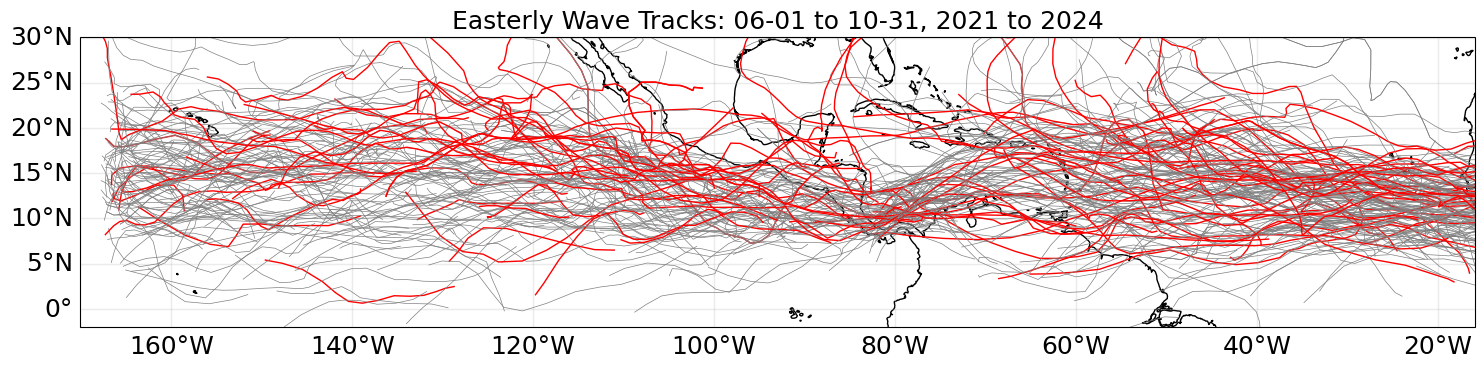

In [27]:
plt.figure(figsize = (18, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution = '50m',linewidth=1,alpha=1)
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, -18, 20))
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

#plot the track density
#cax = ax.imshow(trden_avg, extent=(Xp[0], Xp[-1], Yp[0], Yp[-1]), aspect='auto', cmap='turbo', origin='lower', vmin=0, vmax=0.4)
#plt.pcolormesh(Xp, Yp, trden_avg, vmin=0, vmax=0.4)

# Add colorbar
#cbar=plt.colorbar(orientation='vertical', pad=0.02)
#cbar.set_label('Climo. Track Density',fontsize=18)  #add a label to the colorbar

#plot the AEW tracks each year
nAEW, ntimeAEW = AEWlat_subset.shape[:2]
for j in range(len(years)):
    for i in range(nAEW):
        if isTC[i, j]:
            ax.plot(AEWlon_subset[i, :, j], AEWlat_subset[i, :, j], 'red', linewidth=1)
        else:
            ax.plot(AEWlon_subset[i, :, j], AEWlat_subset[i, :, j], 'gray', linewidth=0.5)
#plot the ship track
#ax.plot(shipLON, shipLAT, 'k', linewidth=2)

#Set the plot limits and title
#cbar.ax.tick_params(labelsize=18)
ax.set_xlim(lon1, lon2)
ax.set_ylim(lat1, lat2)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Easterly Wave Tracks: {mon1:02d}-{day1:02d} to {mon2:02d}-{day2:02d}, {years[0]} to {years[-1]}', fontsize=18)   

Text(0.5, 1.0, 'Easterly Wave Tracks: 06-01 - 10-31, 2024')

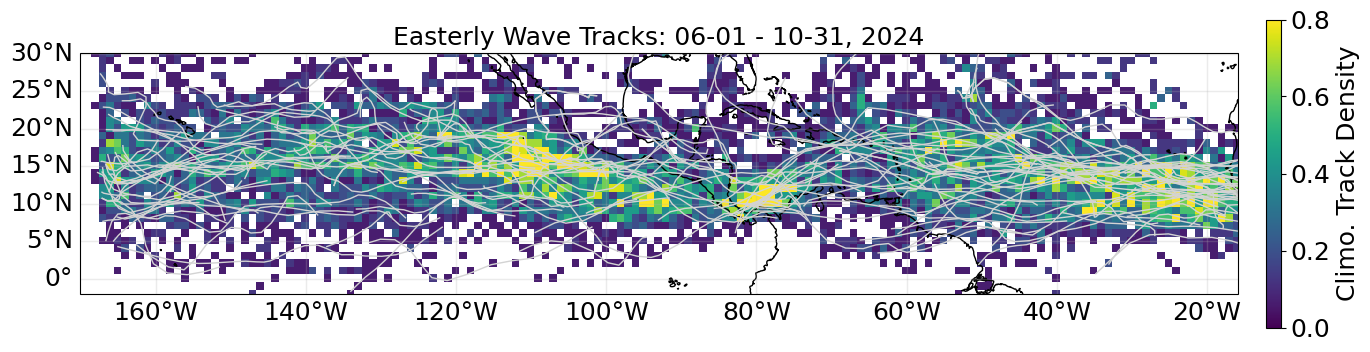

In [18]:
plt.figure(figsize = (18, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution = '50m',linewidth=1,alpha=1)
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, -18, 20))
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

#plot the track density
#cax = ax.imshow(trden_avg, extent=(Xp[0], Xp[-1], Yp[0], Yp[-1]), aspect='auto', cmap='turbo', origin='lower', vmin=0, vmax=0.4)
plt.pcolormesh(Xp, Yp, trden_avg, vmin=0, vmax=0.8)

# Add colorbar
cbar=plt.colorbar(orientation='vertical', pad=0.02)
cbar.set_label('Climo. Track Density',fontsize=18)  #add a label to the colorbar

#plot the AEW tracks in 2024
nAEW2024, ntimeAEW2024 = AEWlat2024.shape
for i in range(nAEW2024):
    ax.plot(AEWlon2024[i, :], AEWlat2024[i, :], 'lightgray', linewidth=1)

#plot the ship track
#ax.plot(shipLON, shipLAT, 'k', linewidth=2)

#Set the plot limits and title
cbar.ax.tick_params(labelsize=18)
ax.set_xlim(lon1, lon2)
ax.set_ylim(lat1, lat2)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Easterly Wave Tracks: {mon1:02d}-{day1:02d} - {mon2:02d}-{day2:02d}, 2024', fontsize=18)   

<>:49: SyntaxWarning: invalid escape sequence '\c'
<>:49: SyntaxWarning: invalid escape sequence '\c'
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_91890/837362703.py:49: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('AEW Latitude at Longitude = 18$^\circ$W')


Text(0.5, 1.0, 'AEW Latitude at Longitude = 18$^\\circ$W')

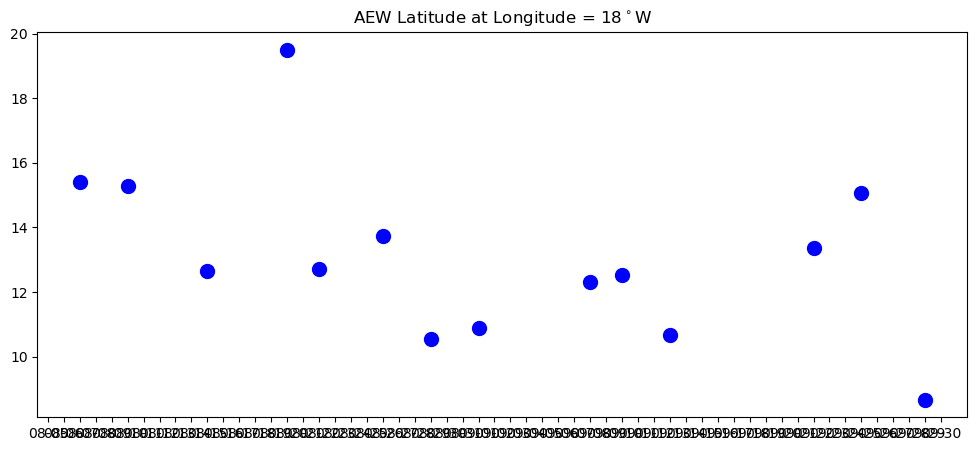

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))
#make month day array from august 1 to september 30
date_range = pd.date_range(start="2024-08-01", end="2024-09-30")
date18_md_reg = [f"{d.month:02d}-{d.day:02d}" for d in date_range]
#make lat18_reg_2024 that is same size as date18_md_reg
lat18_2024_reg = np.full(np.size(date18_md_reg), np.nan)

nAEW2024, ntimeAEW2024 = AEW_lat2024.shape
lat18_2024 = np.full(nAEW2024, np.nan)  # Initialize array to hold latitudes at lon = -18
date18_2024 = [None] * nAEW2024
for i in range(nAEW2024):
    # Interpolate AEW latitude to a longitude of -18
    mask = ~np.isnan(AEW_lon2024[i, :]) & ~np.isnan(AEW_lat2024[i, :])
    lon_masked = AEW_lon2024[i, :][mask]
    lat_masked = AEW_lat2024[i, :][mask]
    dates2024_arr = np.array(dates2024)
    dates_masked = dates2024_arr[mask]

    # Sort by longitude increasing
    sort_idx = np.argsort(lon_masked)
    lon_sorted = lon_masked[sort_idx]
    lat_sorted = lat_masked[sort_idx]
    date_sorted = dates_masked[sort_idx]

    # Only interpolate if -18 is within the range
    if np.nanmin(lon_sorted) <= -18 <= np.nanmax(lon_sorted):
        lat18_2024[i] = np.interp(-18, lon_sorted, lat_sorted)
                # Find the index closest to -18 for the date
        idx_closest = np.argmin(np.abs(lon_sorted + 18))
        # Convert cftime to datetime
        date_cftime = date_sorted[idx_closest]
        try:
            date18_2024[i] = date_cftime.to_datetime()
        except AttributeError:
            date18_2024[i] = pd.to_datetime(str(date_cftime))
    else:
        lat18_2024[i] = np.nan
        date18_2024[i] = None

date18_md_2024 = [f"{d.month:02d}-{d.day:02d}" if d is not None else "" for d in date18_2024]

#fill lat18_2024_reg
for i, md in enumerate(date18_md_2024):
    if md in date18_md_reg:
        lat18_2024_reg[date18_md_reg.index(md)] = lat18_2024[i]


ax.plot(date18_md_reg,lat18_2024_reg, 'o', color='blue', markersize=10)
ax.set_title('AEW Latitude at Longitude = 18$^\circ$W')


<>:69: SyntaxWarning: invalid escape sequence '\c'
<>:71: SyntaxWarning: invalid escape sequence '\c'
<>:69: SyntaxWarning: invalid escape sequence '\c'
<>:71: SyntaxWarning: invalid escape sequence '\c'
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_91890/2492360076.py:69: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('AEW Latitude at Longitude = 18$^\circ$W',fontsize=16)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_91890/2492360076.py:71: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Latitude ($^\circ$N)',fontsize=16)


[Text(0, 0, '08-01'),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, '08-06'),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, '08-11'),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, '08-16'),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, '08-21'),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, '08-26'),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, '08-31'),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, '09-05'),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, '09-10'),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, '09-15'),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, '09-20'),
 Text(51, 0, ''),
 Text(52, 0, ''),
 

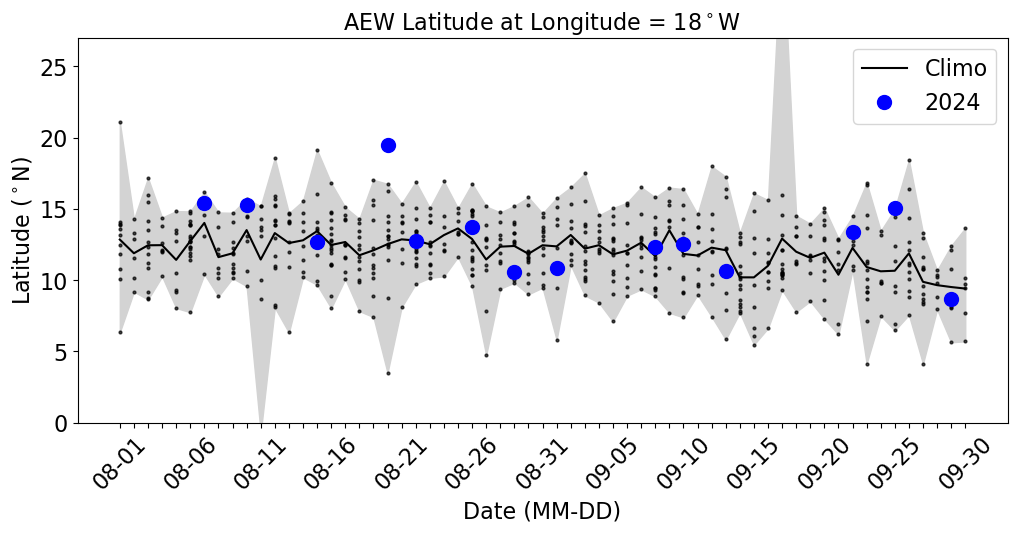

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
#make month day array from august 1 to september 30
date_range = pd.date_range(start="2024-08-01", end="2024-09-30")
date18_md_reg = [f"{d.month:02d}-{d.day:02d}" for d in date_range]

#Get dimensions
nAEW, ntimeAEW, nyears = AEWlat_subset.shape
lat18_reg_allyrs = np.full((np.size(date18_md_reg), nyears), np.nan)

# Loop over each year
for y, year in enumerate(years):

    AEW_lon = AEWlon_subset[:,:,y]    
    AEW_lat = AEWlat_subset[:,:,y]
    lat18 = np.full(nAEW, np.nan)  # Initialize array to hold latitudes at lon = -18
    lat18_reg = np.full(np.size(date18_md_reg), np.nan)
    date18 = [None] * nAEW   
    for i in range(nAEW):
        # Interpolate AEW latitude to a longitude of -18, mask over nan
        mask = ~np.isnan(AEW_lon[i, :]) & ~np.isnan(AEW_lat[i, :])
        lon_masked = AEW_lon[i, :][mask]
        lat_masked = AEW_lat[i, :][mask]
        dates_arr = np.array(dates_subset)
        dates_masked = dates_arr[:,y][mask]

        # Sort by longitude increasing
        sort_idx = np.argsort(lon_masked)
        lon_sorted = lon_masked[sort_idx]
        lat_sorted = lat_masked[sort_idx]
        date_sorted = dates_masked[sort_idx]
        
        #Check if there is data in lon_sorted
        if lon_sorted.size == 0:
            continue

        # Only interpolate if -18 is within the range
        if np.nanmin(lon_sorted) <= -18 <= np.nanmax(lon_sorted):
            lat18[i] = np.interp(-18, lon_sorted, lat_sorted)
            # Find the index closest to -18 for the date
            idx_closest = np.argmin(np.abs(lon_sorted + 18))
            # Convert cftime to datetime
            date_cftime = date_sorted[idx_closest]
            try:
                date18[i] = date_cftime.to_datetime()
            except AttributeError:
                date18[i] = pd.to_datetime(str(date_cftime))
        else:
            lat18[i] = np.nan
            date18[i] = None
                
    date18_md = [f"{d.month:02d}-{d.day:02d}" if d is not None else "" for d in date18]
    #fill lat18_reg
    for i, md in enumerate(date18_md):
        if md in date18_md_reg:
            lat18_reg[date18_md_reg.index(md)] = lat18[i]
    lat18_reg_allyrs[:,y] = lat18_reg
    ax.plot(date18_md_reg,lat18_reg, 'o', color='black', alpha = 0.7, markersize=2)

#climo mean
ax.plot(date18_md_reg,np.nanmean(lat18_reg_allyrs,axis=1), color='black', label='Climo')
#ax.plot(date18_md_reg,np.nanmin(lat18_reg_allyrs,axis=1), color='lightgray')
#ax.plot(date18_md_reg,np.nanmax(lat18_reg_allyrs,axis=1), color='lightgray')
ax.fill_between(date18_md_reg, np.nanmin(lat18_reg_allyrs,axis=1), np.nanmax(lat18_reg_allyrs,axis=1), color='lightgray')

# add 2024
ax.plot(date18_md_reg,lat18_2024_reg, 'o', color='blue', markersize=10,label='2024')

# plot attributes
ax.set_title('AEW Latitude at Longitude = 18$^\circ$W',fontsize=16)
ax.set_xlabel('Date (MM-DD)',fontsize=16)
ax.set_ylabel('Latitude ($^\circ$N)',fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylim(0,27)

xticks = np.arange(len(date18_md_reg))
xticklabels = [date18_md_reg[i] if i % 5 == 0 else "" for i in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45,fontsize=16)        
        